<a href="https://colab.research.google.com/github/PiotMik/NumericalMethodsForSDEs/blob/main/Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Optional
sns.set()
plt.rcParams['figure.figsize'] = (10, 5)

## Poisson process simulation

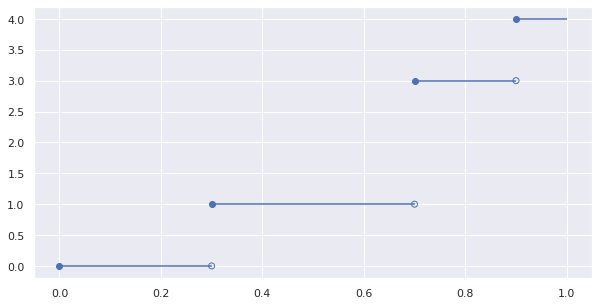

In [63]:
def plot_step(jump_moments, jump_sizes, 
              horizon: Optional[float]=None, is_cadlag = False):
  """
  Plot a step process

  Parameters
  --------
  jump_moments: iterable
    Iterable of floats, moments of jumps
  jump_sizes: iterable
    Iterable of integers, size of jumps
  horizon: Optional[float]
    Maximal xaxis value
  is_cadlag: bool
    Whether to use a cadlag markers
  """
  levels = np.array(jump_sizes).cumsum()
  jump_moments = np.array(jump_moments)

  if jump_moments[0] != 0.0:
    levels = np.concatenate([np.array([0]), levels])
    jump_moments = np.concatenate([np.array([0]), jump_moments])
  if horizon is not None and jump_moments[-1] != horizon:
    levels = np.concatenate([levels, np.array([levels[-1]])])
    jump_moments = np.concatenate([jump_moments, np.array([horizon])])
  
  df = pd.DataFrame.from_dict({'t': jump_moments,
                               'Nt': levels})
  if not is_cadlag:  
    df.set_index('t', inplace=True)
    df.plot(drawstyle="steps-post")
  else:
    fig, ax = plt.subplots()
    for t_left, t_right, level in zip(df['t'][:-1], df['t'][1:], levels):
        ax.hlines(y=level, xmin=t_left, xmax=t_right, color='b')
    ax.scatter(x = df.t[:-1], y = df.Nt[:-1], color='b')
    ax.scatter(x = df.t[1:-1], y = df.Nt[:-2], facecolors='none', edgecolors='b')
  return df  

t = [0.3, 0.7, 0.9]
jump_sizes = [1, 2, 1]
_ = plot_step(jump_moments = t, jump_sizes = jump_sizes,
              horizon=1, is_cadlag=True)

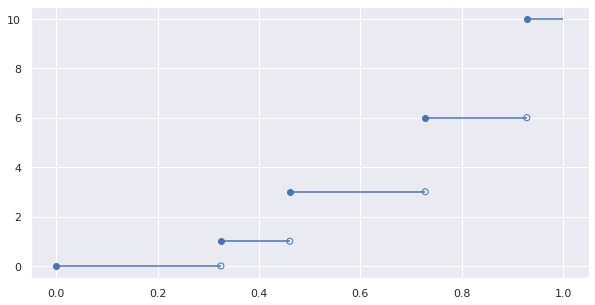

In [67]:
def generate_poisson_process_v1(T:float, lam: float):
  
  t = np.random.exponential(scale=1./lam)
  ys = [0.0]
  xs = [0.0]
  while t < T:
    xs.append(t)
    ys.append(ys[-1] + 1)
    t += np.random.exponential(scale=1./lam)
  return np.array(xs), np.array(ys)

x, y = generate_poisson_process_v1(1, 3)
_ = plot_step(x, y, horizon=1, is_cadlag=True)

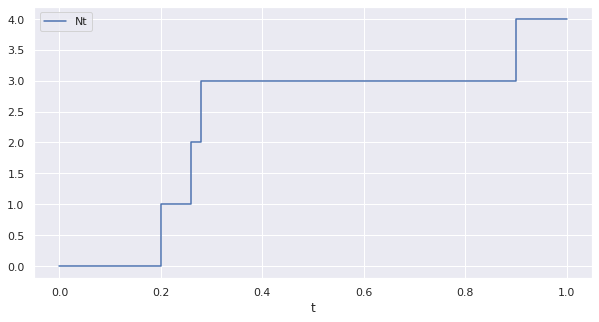

In [94]:
def generate_poisson_process_v2(T:float, lam: float, N: int):
  
  dt = T/N
  t = dt
  ys = [0.0]
  xs = [0.0]
  while t < T:
    n_jumps = np.random.poisson(lam = lam*dt)
    xs.append(t)
    ys.append(n_jumps)
    t += dt
  return np.array(xs), np.array(ys)

x, y = generate_poisson_process_v2(T = 1, lam = 3, N = 50)
_ = plot_step(x, y, horizon=1, is_cadlag=False)

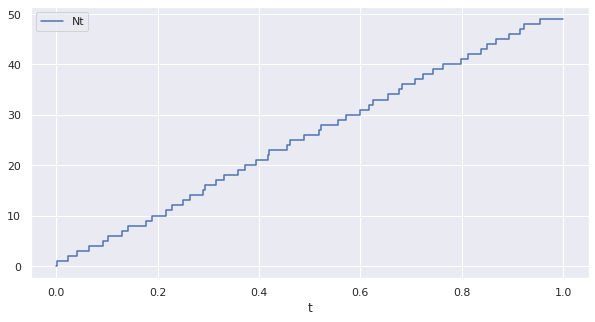

In [95]:
def generate_poisson_process_v3(T: float, lam: float, N: int):
  
  dt = T/N
  t_min = 0.0
  t_max = dt
  ys = [0.0]
  xs = [0.0]
  while t_max + dt < T:
    t_max = min(t_max, T)
    n_jumps = np.random.poisson(lam = lam*dt)
    if n_jumps == 0:
      continue
    else:
      jump_moments = sorted(np.random.uniform(low = t_min, high=t_max, size = n_jumps))
      xs += jump_moments
      ys += [1]*n_jumps
    t_min += dt
    t_max += dt
  return np.array(xs), np.array(ys)

x, y = generate_poisson_process_v3(T = 1, lam = 3, N = 50)
_ = plot_step(x, y, horizon=1, is_cadlag=False)